In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

ModuleNotFoundError: No module named 'sklearn'

In [2]:
df=pd.read_csv('modeling.csv')
round_id=df[['unique_round_id']]
df=df.drop(columns=['unique_round_id'])

#trying out dropping the projected stats to see how it effects data
#df=df.drop(columns=['clinch_attempts_per_control','projected_offensive_clinch_time','projected_offensive_ground_time','projected_ground_control_time_per_takedown','%_offensive_clinch_strikes'])

df=df.replace(np.inf,0)
print(df.dtypes)

%_grappling_control    float64
%_time_standing        float64
dtype: object


Text(0.5, 1.0, 'Inertia of Cosine k-Means versus number of clusters')

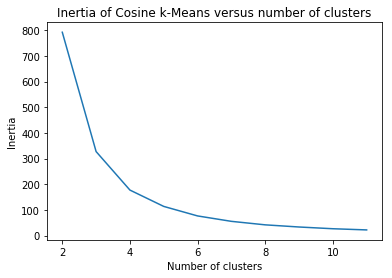

In [3]:
from sklearn import preprocessing
normalized_vectors = preprocessing.normalize(df)
scores = [KMeans(n_clusters=i+2).fit(normalized_vectors).inertia_  
          for i in range(10)]
sns.lineplot(np.arange(2, 12), scores)
plt.xlabel('Number of clusters')
plt.ylabel("Inertia")
plt.title("Inertia of Cosine k-Means versus number of clusters")

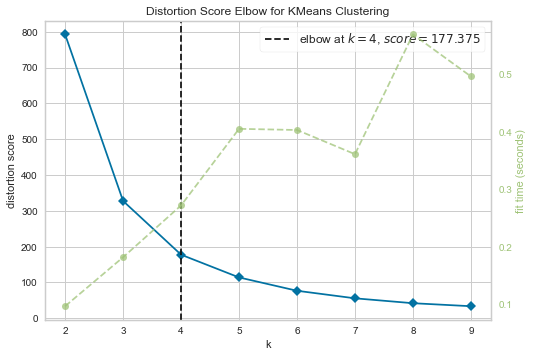

c:\users\jason\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x1C9B6C50>,
                 k=None, model=None)

In [4]:
from yellowbrick.cluster.elbow import kelbow_visualizer
from sklearn.metrics import silhouette_score
normalized_vectors = preprocessing.normalize(df)
kelbow_visualizer(KMeans(random_state=0), normalized_vectors, k=(2,10))

In [5]:
#measuring the silhouette score of the model
from sklearn.metrics import silhouette_score
# Prepare models
normalized_vectors = preprocessing.normalize(df)
normalized_kmeans = KMeans(n_clusters=4).fit(normalized_vectors)
# Print results
print('Cosine kmeans:{}'.format(silhouette_score(normalized_vectors,
                                          normalized_kmeans.labels_,
                                          metric='default',
                                          sample_size=8000)))

Cosine kmeans:0.8273334157284998


In [6]:
#attaching the labels to the data for visualization
df['class']=normalized_kmeans.labels_
print(df.groupby('class').mean())
print(df.columns)
#standing 0
#clinch 1
#ground 2

       %_grappling_control  %_time_standing
class                                      
0                 0.029647         0.764049
1                 0.425439         0.368042
2                 0.232492         0.548072
3                 0.682750         0.165098
Index(['%_grappling_control', '%_time_standing', 'class'], dtype='object')


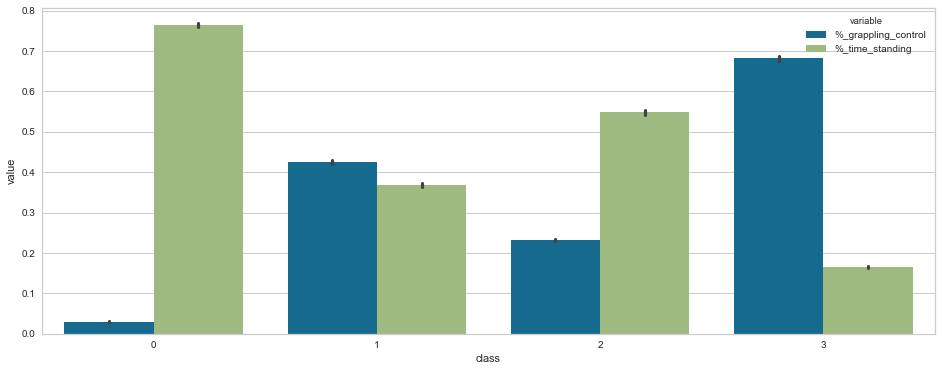

In [7]:
from sklearn.ensemble import RandomForestClassifier

subset=df
#subset=df.loc[df['class']!=1]
#subset=subset.loc[df['class']!=2]


X, y = subset.iloc[:,:-1], subset.iloc[:,-1]
clf = RandomForestClassifier(n_estimators=100).fit(X, y)
data = np.array([clf.feature_importances_, X.columns]).T
columns = list(pd.DataFrame(data, columns=['Importance', 'Feature'])
           .sort_values("Importance", ascending=False)
           .Feature.values)
tidy = subset[columns+['class']].melt(id_vars='class')
plt.figure(figsize=(16, 6))
sns.barplot(x='class', y='value', hue='variable', data=tidy)

In [8]:
#concatting data
df=pd.concat([df,round_id],axis=1)

#how many of each class
print(df['class'].value_counts())

df=df[['unique_round_id','class']]
df=df.rename(columns={'class':'strategic_class'})

df.to_csv('classification.csv',index=False)
#df.to_csv('Tactical Offensive Classifier/Striking Class/Transformation/classification.csv',index=False)
#df.to_csv('Tactical Offensive Classifier/Ground Class/Transformation/classification.csv',index=False)
#df.to_csv('Tactical Offensive Classifier/Clinch Class/Transformation/classification.csv',index=False)
#df.to_csv('Tactical Offensive Classifier/Balanced Class/Transformation/classification.csv',index=False)

#importing data
data = pd.read_csv('comparer.csv')

#merging data
df=df.merge(data, on='unique_round_id',how='left')
df=df.drop(columns=['unique_round_id'])

0    11621
2     3431
3     2747
1     2515
Name: class, dtype: int64


In [9]:
print(len(df.index))
print(df.groupby('strategic_class').mean())

20314
                 total_round_time  knockdowns  total_strikes_landed  \
strategic_class                                                       
0                      291.016522    0.069271             21.050770   
1                      290.900596    0.074354             26.698211   
2                      292.220635    0.083066             24.148062   
3                      289.906443    0.045868             32.987623   

                 total_strikes_attempted  takedowns  takedowns_attempted  \
strategic_class                                                            
0                              48.039067   0.142587             0.743568   
1                              42.794036   0.972962             2.168986   
2                              45.164092   0.647042             1.812883   
3                              44.945395   1.233710             2.180925   

                 submission_attempts  reversals  guard_passes  \
strategic_class                              

In [10]:
# saving the model
import pickle
filename = 'STRATEGIC_OFFENSE.sav'
pickle.dump(normalized_kmeans, open(filename, 'wb'))